In this notebook, we,

1. Create a basic stochastic Multi-Armed Bandit (MAB) environment;
2. Create a epsilon-greedy player and an adaptive epsilon-greedy player;
3. Simuate the two party two-party game between the environment and a MAB player.



In [14]:
import numpy as np
class MultiArmedBanditEnvironment:
    """ Class for the multi-armed bandit environment.
    """

    def __init__(self, arm_num=3, arm_type='stochastic-normal') -> None:
        self._arms_mean_reward = [0.2 + 0.5 * i for i in range(arm_num)]
        self._arm_type = arm_type

    def generate_reward(self, played_arm)-> float:
        """ Generate reward if the input arm is played.
        """
        assert played_arm in range(len(self._arms_mean_reward)), 'Arm does not exist.'
        if 'stochastic' in self._arm_type and 'normal' in self._arm_type:
            return np.random.normal(self._arms_mean_reward[played_arm], 0.5 , 1)
        else:
            NotImplementedError

In [15]:
class MultiArmedBanditPlayer:
    """ Class for the multi-armed bandit player/algorithm
    """

    def __init__(self, arm_num=3, epsilon=None, total_budget=10):
        # this is needed in general
        self._arm_num = arm_num
        self._arms_mean_reward_estimate = [0.1] * arm_num
        self._arms_times_played = [0] * arm_num
        # this is needed for epsilon-style algorithm
        self._epsilon = epsilon
        self._total_budget = total_budget
        self._total_budget_used = 0.0
    
    def act(self) -> int:
        """ Pull and return an arm. This is the place you implement your 
        arm selection strategy.
        """
        NotImplementedError 

    def learn(self, arm, reward):
        """ Update your model. This is the place where you (the player/algorithm)
        digest the feedback received.
        """
        NotImplementedError

    def is_budget_left(self):
        return True if (self._total_budget - self._total_budget_used)  > 0 else False


class EpsilonGreedyPlayer(MultiArmedBanditPlayer):
    """Class for the epsilon greedy player.
    """



    def act(self):
        self._total_budget_used += 1.0
        eps = np.random.uniform(0, 1, 1)
        if eps < self._epsilon:
            # random exploration
            return np.random.randint(self._arm_num)
        else:
            # being greedy based on the empirical mean, break tie randomly
            arm_reward = np.array(self._arms_mean_reward_estimate)
            best_arms = np.flatnonzero(arm_reward == arm_reward.max())
            return np.random.choice(best_arms)

    def learn(self, arm, reward):
        # update the empirical reward and the number of times the arm is played
        self._arms_mean_reward_estimate[arm] = self._arms_mean_reward_estimate[arm] + \
            (reward - self._arms_mean_reward_estimate[arm]) / (self._arms_times_played[arm] + 1)
        # note this is equivent to the following more straightforward equation
        # self._arms_mean_reward_estimate[arm] = (self._arms_mean_reward_estimate[arm] * self._arms_times_played[arm]
        #     + reward)/ (self._arms_times_played[arm] + 1)
        self._arms_times_played[arm] += 1


class AdaptiveEpsilonGreedyPlayer(EpsilonGreedyPlayer):


    def __init__(self, arm_num=3, epsilon=0, total_budget=10):
        super().__init__(arm_num, epsilon, total_budget)
        self._init_epsilon = epsilon

    def learn(self, arm, reward):
        super().learn(arm, reward)
        self._epsilon = self._init_epsilon/np.sqrt(self._total_budget_used)


class UCB1Player(EpsilonGreedyPlayer):


    def __init__(self, arm_num=3, epsilon=0, total_budget=10):
        super().__init__(arm_num, epsilon, total_budget)
        # initial values for CB
        self._arms_CB = [1.0] * arm_num

    def act(self):
        for i in range(self._arm_num):
            if self._arms_times_played[i] == 0:
                return i
        self._total_budget_used += 1.0
        arms_UCB = np.array([self._arms_mean_reward_estimate[i] + self._arms_CB[i] for i in range(self._arm_num)])
        best_arms = np.flatnonzero(arms_UCB == arms_UCB.max())
        return np.random.choice(best_arms)

    def learn(self, arm, reward):
        super().learn(arm, reward)
        # update CB
        self._arms_CB[arm] = np.sqrt(2*np.log(self._total_budget)/self._arms_times_played[arm])

    

In [16]:
# Simulate the game between the environment and the player
total_budget = 500
arm_num = 5
mab_env = MultiArmedBanditEnvironment(arm_num=arm_num)
greedy_player = EpsilonGreedyPlayer(arm_num=arm_num, epsilon=0.0, total_budget=total_budget)
greedy_player05 = EpsilonGreedyPlayer(arm_num=arm_num, epsilon=0.5, total_budget=total_budget)
greedy_player01 = EpsilonGreedyPlayer(arm_num=arm_num, epsilon=0.1, total_budget=total_budget)
greedy_player001 = EpsilonGreedyPlayer(arm_num=arm_num, epsilon=0.001, total_budget=total_budget)
adaptive_greedy = AdaptiveEpsilonGreedyPlayer(arm_num=arm_num, epsilon=1.0, total_budget=total_budget)
ucb1 = UCB1Player(arm_num=arm_num, epsilon=1.0, total_budget=total_budget)
players = {"greedy_player": greedy_player,
"greedy_player05": greedy_player05,
"greedy_player01": greedy_player01,
"greedy_player001": greedy_player001,
"adaptive_greedy": adaptive_greedy,
"ucb1": ucb1,
}

players_reward = {}
for k, mab_player in players.items():
    player_reward = []
    budget_left = True
    counter = 0
    while budget_left:
        # the player select an arm
        arm_pulled = mab_player.act()
        # the environment gives the reward
        reward = mab_env.generate_reward(arm_pulled)
        # the player learn
        mab_player.learn(arm_pulled, reward)
        player_reward.append(reward)
        # print(arm_pulled, reward)
        budget_left = mab_player.is_budget_left()
        # print(budget_left)
        counter +=1
    players_reward[k] = player_reward

    

/var/folders/9z/yw_pb4hs1r3481yq2cszk6s97zvj_s/T/ipykernel_76361/2805253045.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arm_reward = np.array(self._arms_mean_reward_estimate)
/var/folders/9z/yw_pb4hs1r3481yq2cszk6s97zvj_s/T/ipykernel_76361/2805253045.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arms_UCB = np.array([self._arms_mean_reward_estimate[i] + self._arms_CB[i] for i in range(self._arm_num)])


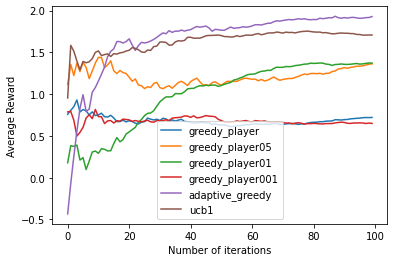

In [17]:
# plot
import matplotlib.pyplot as plt
import numpy as np
for k, player_reward in players_reward.items():
    player_progressive_avg_reward = [sum(player_reward[:i])/i for i in range(1, len(player_reward)+1)]
    plt.xlabel('Number of iterations')
    plt.ylabel('Average Reward')
    plt.plot(range(len(player_reward)), player_progressive_avg_reward, label=k)
    plt.legend()

# Obervations
- Pure greedy is sensitive to the initial values of each arm
- Epsilon-greedy is sentitive to `epsilon` and how to set `epsilon` is non-trivial
- Adaptive-greedy seems a robust alternative of epsilon-greedy